# Train Wreck Analysis

## Project abstract
Use train wreck datasets http://www.trainwreckdb.com/ with spark service in bluemix to figure out what are the 10 most dangerous places for accidents and why.

## Procedures
1. Collect data from the website and upload it to Object Storage.
2. Processing the dataset
    - Split the data
    - Filter the data
    - Perform Map and Reduce on the data
3. Analyze the data and come to the conclusion.

## Load Data
The dataset I have used is retrieved from http://www.trainwreckdb.com. It is about Train wreck cases in the US since 1997. The data is in tab delimited text format with name train-wreck-data.txt

In [1]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [2]:
credentials_9 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_5f6b0270_4150_4b14_81a5_8ff30037bb47',
  'project_id':'11f9aa6b77984ec59f19a117b511bfab',
  'region':'dallas',
  'user_id':'f3531cd7a7234ff8b090ba5326653890',
  'domain_id':'07e4e1c0b8d9425c8d33ed28df6b8069',
  'domain_name':'964113',
  'username':'Admin_c5fb744b8aac9795f657b9c2c0963c03e56d7097',
  'password':"""M59sL&Ochli*u_~R""",
  'filename':'train-wreck-data.txt',
  'container':'notebooks',
  'tenantId':'sb8b-d43cdd7c2fbf91-8b6318a1cff4'
}

In [3]:
credentials_9['name'] = 'mykey'
set_hadoop_config(credentials_9)

With the raw data file stored in Object Storage, I can now access it using the configured `SparkContext` in our notebook. 

In [4]:
train_wreck = sc.textFile("swift://notebooks.mykey/train-wreck-data.txt")

In [5]:
print "Total records in the train-wreck-data.txt dataset:", train_wreck.count()

Total records in the train-wreck-data.txt dataset: 52458


In [6]:
print "The first row of train-wreck-data.txt dataset:\n", train_wreck.first()

The first row of train-wreck-data.txt dataset:
Date	"City, State"	Street	Railroad	Description


## Parse Data

I parse the data by splitting each row by tab delimiter

In [7]:
twParse = train_wreck.map(lambda line : line.split("\t"))

In [8]:
twParse.first()

[u'Date', u'"City, State"', u'Street', u'Railroad', u'Description']

To explore data, I filter out the first row

In [9]:
twParse = twParse.filter(lambda x: str(x[0]) != "Date")

In [10]:
twParse.first()

[u'12/31/15 23:58',
 u'"CHESTER, VIRGINIA"',
 u'CENTRALIA ROAD',
 u'CSX Transportation',
 u'Q43930 STRUCK A VEHICLE/VETERANS CAB THAT HAD FOULED THE #1 MAIN AT CROSSING. NO INJURIES. DRIVERS AGE UNKNOWN. PROTECTION ALSO AT CROSSING: ADVANCE WARNING AND PAVEMENT MARKINGS (STOP LINES & RR XING SYMBOLS).']

## Explore and Analyze Data
### 1. Find out 10 most dangerous Cities for train accidents

In the dataset, some rows contain City name in field "City, State", some do not. In order to analyze the data regarding the City, I do filtering to get rows only containing City name in the dataset.

In [11]:
# x[1] is the "City, State" 
twCity = twParse.filter(lambda x: ("," in x[1]) and ("N/A," not in x[1]))

In [12]:
twCity.first()

[u'12/31/15 23:58',
 u'"CHESTER, VIRGINIA"',
 u'CENTRALIA ROAD',
 u'CSX Transportation',
 u'Q43930 STRUCK A VEHICLE/VETERANS CAB THAT HAD FOULED THE #1 MAIN AT CROSSING. NO INJURIES. DRIVERS AGE UNKNOWN. PROTECTION ALSO AT CROSSING: ADVANCE WARNING AND PAVEMENT MARKINGS (STOP LINES & RR XING SYMBOLS).']

Perform Map and Reduce to retrieve data information

In [13]:
# x[1] is the "City, State" 
twCityCountByKey = twCity.map(lambda x : (str(x[1]), 1))

In [14]:
twCityCountByKey.first()

('"CHESTER, VIRGINIA"', 1)

In [15]:
twCityAddByKey = twCityCountByKey.reduceByKey(lambda v1,v2 : (v1+v2)).sortByKey()

In [15]:
twCityAddByKey.collect()

[('"AB CHANCE, TEXAS"', 1),
 ('"ABBEVILLE, ALABAMA"', 1),
 ('"ABBEVILLE, LOUISIANA"', 6),
 ('"ABBOTT, ARKANSAS"', 1),
 ('"ABBOTTSBURG, NORTH CAROLINA"', 1),
 ('"ABERDEEN, IDAHO"', 2),
 ('"ABERDEEN, MARYLAND"', 3),
 ('"ABERDEEN, NORTH CAROLINA"', 5),
 ('"ABERDEEN, SOUTH DAKOTA"', 6),
 ('"ABERDEEN, WASHINGTON"', 3),
 ('"ABERNANT, ALABAMA"', 1),
 ('"ABERNATHY, TEXAS"', 2),
 ('"ABILENE, KANSAS"', 4),
 ('"ABILENE, TEXAS"', 6),
 ('"ABILENE, VIRGINIA"', 1),
 ('"ABINGDON, ILLINOIS"', 2),
 ('"ABINGDON, VIRGINIA"', 6),
 ('"ABINGTON, MASSACHUSETTS"', 7),
 ('"ABINGTON, PENNSYLVANIA"', 1),
 ('"ABOITE, INDIANA"', 2),
 ('"ABRAMS, WISCONSIN"', 1),
 ('"ACAMPO, CALIFORNIA"', 2),
 ('"ACCOVILLE, WEST VIRGINIA"', 2),
 ('"ACEQUIA, IDAHO"', 1),
 ('"ACKERMAN, MISSISSIPPI"', 6),
 ('"ACKLEY, IOWA"', 2),
 ('"ACME, MICHIGAN"', 1),
 ('"ACME, NORTH CAROLINA"', 2),
 ('"ACTON, CALIFORNIA"', 2),
 ('"ACTON, INDIANA"', 3),
 ('"ACTON, MASSACHUSETTS"', 1),
 ('"ACWORTH, GEORGIA"', 15),
 ('"ADA, MICHIGAN"', 1),
 ('"ADA, OHI

Output the 10 cities with the highest number of train accidents since 1997

In [16]:
acdsTop10=[]
citiesTop10=[]
for pair in twCityAddByKey.map(lambda (x,y) : (y,x)).top(10):
    acdsTop10.append(pair[0])
    citiesTop10.append(pair[1])
    print "City %s had %d train wreck cases" % (pair[1],pair[0])

City "HOUSTON, TEXAS" had 453 train wreck cases
City "CHICAGO, ILLINOIS" had 357 train wreck cases
City "MEMPHIS, TENNESSEE" had 187 train wreck cases
City "SAN ANTONIO, TEXAS" had 175 train wreck cases
City "LOUISVILLE, KENTUCKY" had 174 train wreck cases
City "BATON ROUGE, LOUISIANA" had 167 train wreck cases
City "PHOENIX, ARIZONA" had 159 train wreck cases
City "GARY, INDIANA" had 156 train wreck cases
City "JACKSONVILLE, FLORIDA" had 151 train wreck cases
City "LOS ANGELES, CALIFORNIA" had 139 train wreck cases


Visualize the information retrieved in bar chart

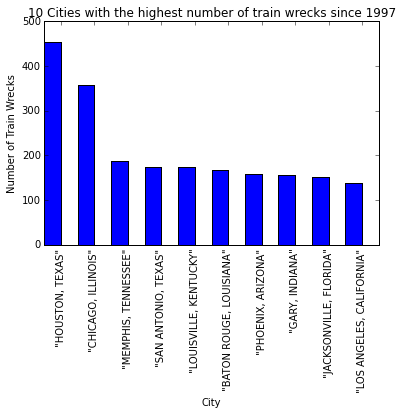

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 10
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, acdsTop10, bar_width,
                 color='b')
plt.xlabel('City')
plt.ylabel('Number of Train Wrecks')
plt.title('10 Cities with the highest number of train wrecks since 1997')
plt.xticks(index + bar_width, citiesTop10, rotation=90)
plt.show()

###From the graph above, we can safely conclude that these Cities are 10 most dangerous places for train accidents. Houston, Texas and Chicago, Illinois are extremely dangerous with  453 and 357 cases respectively.

### 2. Find out 10 most dangerous States for train accidents

In order to analyze the data regarding the State, I do a mapping on dataset in which for those rows containing city and state information in field "City, State", only the State name is extracted.

In [18]:
twParse.first()

[u'12/31/15 23:58',
 u'"CHESTER, VIRGINIA"',
 u'CENTRALIA ROAD',
 u'CSX Transportation',
 u'Q43930 STRUCK A VEHICLE/VETERANS CAB THAT HAD FOULED THE #1 MAIN AT CROSSING. NO INJURIES. DRIVERS AGE UNKNOWN. PROTECTION ALSO AT CROSSING: ADVANCE WARNING AND PAVEMENT MARKINGS (STOP LINES & RR XING SYMBOLS).']

In [19]:
twStateCountByKey = twParse.map(lambda x : (  
        str(x[1][x[1].index(',')+2:-1]) if ("," in x[1]) else str(x[1])
        , 1))

In [20]:
twStateCountByKey.first()

('VIRGINIA', 1)

Perform Reduce on this Map

In [21]:
twStateAddByKey = twStateCountByKey.reduceByKey(lambda v1,v2 : (v1+v2)).sortByKey()

In [22]:
twStateAddByKey.collect()

[('', 12),
 ('ALABAMA', 1946),
 ('ALASKA', 43),
 ('ARIZONA', 532),
 ('ARKANSAS', 1415),
 ('CALIFORNIA', 2880),
 ('COLORADO', 555),
 ('CONNECTICUT', 104),
 ('DC, DISTRICT OF COLUMBIA', 3),
 ('DELAWARE', 115),
 ('DISTRICT OF COLUMBIA', 2),
 ('FLORIDA', 1625),
 ('GEORGIA', 2283),
 ('HAWAII', 1),
 ('IDAHO', 393),
 ('ILLINOIS', 3070),
 ('INDIANA', 2853),
 ('IOWA', 1385),
 ('KANSAS', 1111),
 ('KENTUCKY', 1292),
 ('LOUISIANA', 2510),
 ('MAINE', 104),
 ('MARYLAND', 318),
 ('MASSACHUSETTS', 217),
 ('ME, MAINE', 3),
 ('MICHIGAN', 1600),
 ('MINNESOTA', 1305),
 ('MISSISSIPPI', 1496),
 ('MISSOURI', 1201),
 ('MONTANA', 361),
 ('NC, NORTH CAROLINA', 1),
 ('NEBRASKA', 875),
 ('NEVADA', 50),
 ('NEW HAMPSHIRE', 32),
 ('NEW JERSEY', 658),
 ('NEW MEXICO', 271),
 ('NEW YORK', 663),
 ('NORTH CAROLINA', 1388),
 ('NORTH DAKOTA', 370),
 ('OHIO', 2187),
 ('OKLAHOMA', 1203),
 ('OREGON', 487),
 ('PENNSYLVANIA', 1264),
 ('RHODE ISLAND', 7),
 ('SH, MASSACHUSETTS', 1),
 ('SMYRN, MAINE', 1),
 ('SOUTH CAROLINA', 1142)

Output the 10 States with the highest number of train accidents since 1997

In [23]:
acdsTop10=[]
statesTop10=[]
for pair in twStateAddByKey.map(lambda (x,y) : (y,x)).top(10):
    acdsTop10.append(pair[0])
    statesTop10.append(pair[1])
    print "State %s had %d train wreck cases" % (pair[1],pair[0])

State TEXAS had 5511 train wreck cases
State ILLINOIS had 3070 train wreck cases
State CALIFORNIA had 2880 train wreck cases
State INDIANA had 2853 train wreck cases
State LOUISIANA had 2510 train wreck cases
State GEORGIA had 2283 train wreck cases
State OHIO had 2187 train wreck cases
State ALABAMA had 1946 train wreck cases
State FLORIDA had 1625 train wreck cases
State MICHIGAN had 1600 train wreck cases


Visualize the information retrieved in bar chart

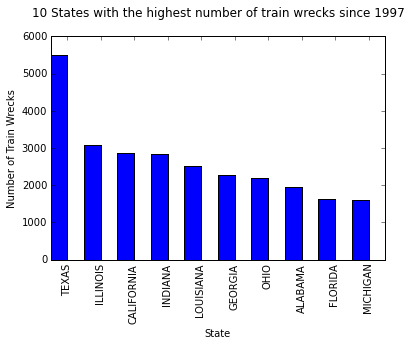

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 10
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, acdsTop10, bar_width,
                 color='b')
plt.xlabel('State')
plt.ylabel('Number of Train Wrecks')
plt.title('10 States with the highest number of train wrecks since 1997\n')
plt.xticks(index + bar_width, statesTop10, rotation=90)
plt.show()

###From the graph above, we can safely conclude that these States are 10 most dangerous places for train accidents. Texas, Illinois and California are most dangerous with  5511,  3070 and 2880 cases respectively.